In [8]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, avg, count, to_date

# Initialize Spark
spark = SparkSession.builder.appName("RetailDataProcessing").getOrCreate()


25/10/04 07:58:32 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [9]:
import os
print(os.path.exists("C:/Users/surenderaa99/CarSales.csv"))


False


In [10]:

df = spark.read.csv("hdfs:///user/surenderaa99/car_sales", header=True, inferSchema=True)
df.show(5)


+------+------------------+-----------------+------+--------+------+--------+------------+-----+-------+--------------------+----------+------------------+-------------------+--------------------+--------------------+-------------------+
| brand|              name|         bodyType| color|fuelType|  year| mileage|transmission|power|  price|vehicleConfiguration|engineName|engineDisplacement|               date|            location|                link|         parse_date|
+------+------------------+-----------------+------+--------+------+--------+------------+-----+-------+--------------------+----------+------------------+-------------------+--------------------+--------------------+-------------------+
|Toyota|Land Cruiser Prado|     jeep 5 doors|  blue|  Diesel|1995.0|168000.0|          AT|130.0|1860000|3.0 SX Wide limit...|    1KZ-TE|           3.0 LTR|2022-08-20 00:00:00|Petropavlovsk-Kam...|https://petropavl...|2022-08-20 04:00:00|
|Toyota|      Land Cruiser|     jeep 5 doors| bl

In [11]:
import subprocess

result = subprocess.run(['hdfs', 'dfs', '-ls', '/user/surenderaa99/car_sales'], capture_output=True, text=True)
print(result.stdout)


Found 1 items
-rw-r--r--   2 surenderaa99 hadoop  336866560 2025-10-01 14:16 /user/surenderaa99/car_sales/CarSales.csv



In [39]:

# Basic EDA
df.printSchema()
df.describe().show()


root
 |-- brand: string (nullable = true)
 |-- name: string (nullable = true)
 |-- bodyType: string (nullable = true)
 |-- color: string (nullable = true)
 |-- fuelType: string (nullable = true)
 |-- year: double (nullable = true)
 |-- mileage: double (nullable = true)
 |-- transmission: string (nullable = true)
 |-- power: double (nullable = true)
 |-- price: integer (nullable = true)
 |-- vehicleConfiguration: string (nullable = true)
 |-- engineName: string (nullable = true)
 |-- engineDisplacement: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- location: string (nullable = true)
 |-- link: string (nullable = true)
 |-- parse_date: timestamp (nullable = true)



+-------+-------+------------------+-------------+-------+--------+------------------+------------------+------------+-----------------+------------------+--------------------+----------+------------------+---------+--------------------+
|summary|  brand|              name|     bodyType|  color|fuelType|              year|           mileage|transmission|            power|             price|vehicleConfiguration|engineName|engineDisplacement| location|                link|
+-------+-------+------------------+-------------+-------+--------+------------------+------------------+------------+-----------------+------------------+--------------------+----------+------------------+---------+--------------------+
|  count|1498740|           1498740|      1498740|1448934| 1492145|            915699|           1491876|     1491339|          1484500|           1498740|              915699|    915506|            914866|  1498740|             1498740|
|   mean|   null|1929.4592757384748|         nul

In [19]:

# Data Cleaning
df_clean = df.dropna()


In [20]:
from pyspark.sql.functions import sum, avg, col

# Group by brand and aggregate sales
sales_per_product = df_clean.groupBy("brand").agg(
    sum("price").alias("TotalSales"),
    avg("price").alias("AvgSales")
).orderBy(col("TotalSales").desc())

sales_per_product.show(10)

# Filter high-sales brands
high_sales = sales_per_product.filter(col("TotalSales") > 100000)
high_sales.show(10)


+-------------+------------+------------------+
|        brand|  TotalSales|          AvgSales|
+-------------+------------+------------------+
|       Toyota|534672539035|1416043.5058742207|
|        Lexus|223913794694|3299157.1341387946|
|   Mitsubishi| 68300102861|1143136.2198065207|
|        Honda| 65676500348|  787327.527338552|
|       Nissan| 65496579424|  809349.143330244|
|       Subaru| 51836949550|  977944.941138739|
|Mercedes-Benz| 40719813000|3414373.0504779476|
|       Suzuki| 37293520527| 689739.4168007546|
|         Jeep| 13464350000|4039708.9708970897|
|     Infiniti| 12657897351|1165444.9268943928|
+-------------+------------+------------------+
only showing top 10 rows



+-------------+------------+------------------+
|        brand|  TotalSales|          AvgSales|
+-------------+------------+------------------+
|       Toyota|534672539035|1416043.5058742207|
|        Lexus|223913794694|3299157.1341387946|
|   Mitsubishi| 68300102861|1143136.2198065207|
|        Honda| 65676500348|  787327.527338552|
|       Nissan| 65496579424|  809349.143330244|
|       Subaru| 51836949550|  977944.941138739|
|Mercedes-Benz| 40719813000|3414373.0504779476|
|       Suzuki| 37293520527| 689739.4168007546|
|         Jeep| 13464350000|4039708.9708970897|
|     Infiniti| 12657897351|1165444.9268943928|
+-------------+------------+------------------+
only showing top 10 rows



In [14]:
from pyspark.sql.functions import when, col

# Add a dummy Churn column: mark cars with price > 1 million as "Churned"
df_clean = df_clean.withColumn("Churn", when(col("price") > 1000000, 1).otherwise(0))


In [15]:


from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

# Feature columns
feature_cols = ["price", "mileage", "year", "power"]

# Vectorize features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_features = assembler.transform(df_clean)

# KMeans model
kmeans = KMeans(featuresCol="features", k=3)
model = kmeans.fit(df_features)

# Make predictions (assign clusters)
predictions = model.transform(df_features)
predictions.select("price", "mileage", "year", "power", "prediction").show(10)


+-------+--------+------+-----+----------+
|  price| mileage|  year|power|prediction|
+-------+--------+------+-----+----------+
|1860000|168000.0|1995.0|130.0|         0|
|1075000|100000.0|2019.0| 95.0|         0|
| 480000|239000.0|2002.0|160.0|         0|
|1450000|101000.0|2010.0|170.0|         0|
|6777777| 95000.0|2002.0|315.0|         1|
| 929000|143000.0|2005.0|170.0|         0|
|1760000| 95000.0|2015.0|150.0|         0|
|1500000|232000.0|2000.0|185.0|         0|
| 880000| 85000.0|2011.0|103.0|         0|
|1590000|175000.0|2012.0|146.0|         0|
+-------+--------+------+-----+----------+
only showing top 10 rows



<AxesSubplot:>

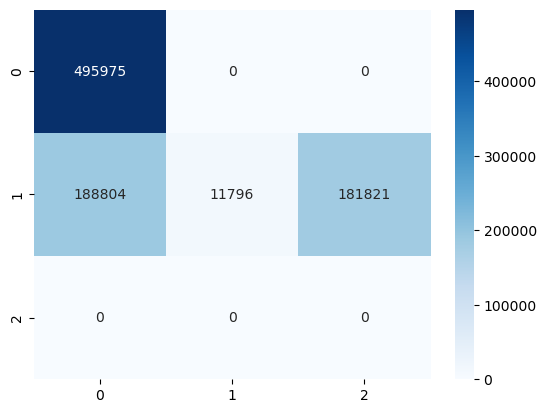

In [16]:
import pandas as pd

# Convert to Pandas
pandas_df = predictions.select("prediction", "Churn").toPandas()

# Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(pandas_df["Churn"], pandas_df["prediction"])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


In [21]:
from pyspark.ml.feature import StandardScaler

# Assemble features
assembler = VectorAssembler(inputCols=["price", "mileage", "year", "power"], outputCol="features_raw")
df_assembled = assembler.transform(df_clean.select("price", "mileage", "year", "power").dropna())

# Scale features
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)


In [22]:

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_scores = []

for k in range(2, 8):
    kmeans = KMeans(featuresCol="features", predictionCol="prediction", k=k)
    model = kmeans.fit(df_scaled)
    predictions = model.transform(df_scaled)
    
    evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction", metricName="silhouette", distanceMeasure="squaredEuclidean")
    score = evaluator.evaluate(predictions)
    
    silhouette_scores.append((k, score))
    print(f"Silhouette Score for k={k}: {score:.4f}")


Silhouette Score for k=2: 0.4753


Silhouette Score for k=3: 0.5110


Silhouette Score for k=4: 0.5319


Silhouette Score for k=5: 0.4369


Silhouette Score for k=6: 0.3978


Silhouette Score for k=7: 0.4096


In [24]:

best_k = 3
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=best_k)
model = kmeans.fit(df_scaled)
final_predictions = model.transform(df_scaled)


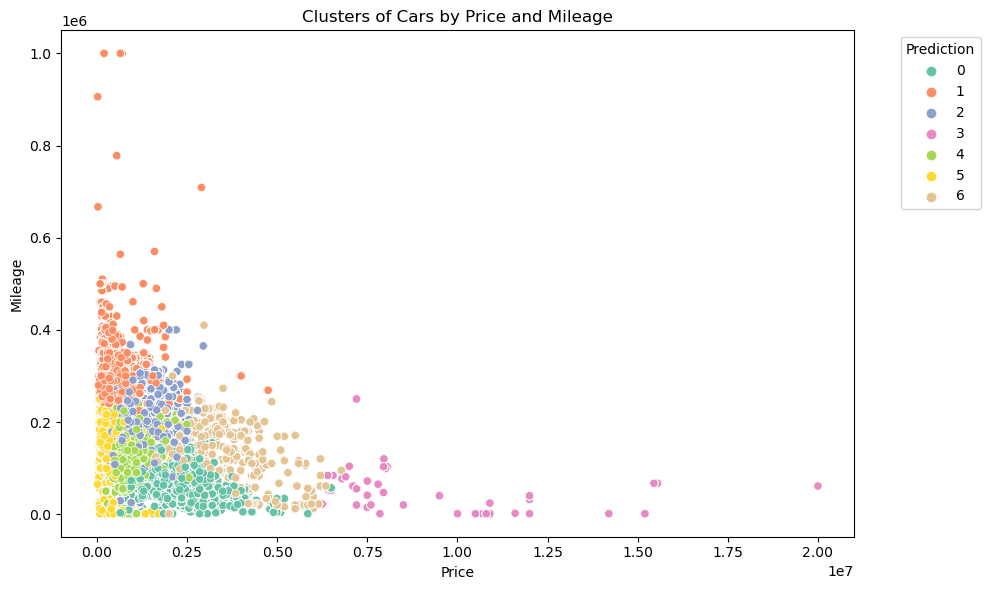

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to Pandas
# Correct: select existing columns only
pandas_df = predictions.select("price", "mileage", "prediction").toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pandas_df, x="price", y="mileage", hue="prediction", palette="Set2")

plt.title("Clusters of Cars by Price and Mileage")
plt.xlabel("Price")
plt.ylabel("Mileage")
plt.legend(title="Prediction", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [28]:
print(pandas_df.columns)


Index(['price', 'mileage', 'prediction'], dtype='object')


In [29]:
# Keep only the existing columns: price, mileage, prediction
pandas_df = predictions.select("price", "mileage", "prediction").toPandas()


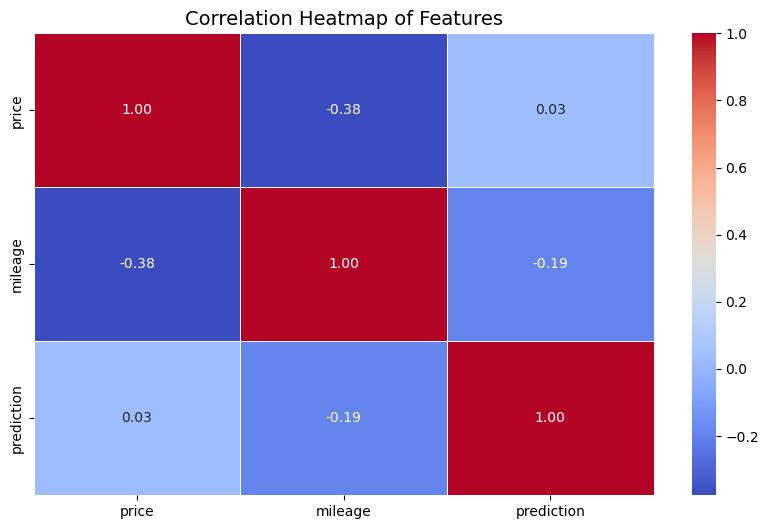

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example: assuming pandas_df contains numeric columns like price, mileage, year, power
# Compute correlation matrix
corr = pandas_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Correlation Heatmap of Features", fontsize=14)
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 1. Basic Info & Overview
# -----------------------------
print("Shape of dataset:", pandas_df.shape)
print("\nColumns:\n", pandas_df.columns)
print("\nData types:\n", pandas_df.dtypes)
print("\nMissing values:\n", pandas_df.isnull().sum())
print("\nSummary statistics:\n", pandas_df.describe())

# -----------------------------
# 2. Univariate Analysis
# -----------------------------
# Histograms for numeric features
pandas_df.hist(figsize=(12, 8), bins=30, edgecolor='black')
plt.suptitle("Distribution of Numeric Features", fontsize=16)
plt.show()

# Boxplots for numeric features (detect outliers)
plt.figure(figsize=(12, 6))
sns.boxplot(data=pandas_df.select_dtypes(include=["int64", "float64"]))
plt.title("Boxplots of Numeric Features", fontsize=14)
plt.xticks(rotation=45)
plt.show()

# -----------------------------
# 3. Correlation Analysis
# -----------------------------
corr = pandas_df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap", fontsize=14)
plt.show()

# Pairplot (only for selected columns to avoid heavy plots)
selected_cols = ["price", "mileage", "year", "power"]  # adjust to your dataset
sns.pairplot(pandas_df[selected_cols], diag_kind="kde")
plt.suptitle("Pairplot of Selected Features", y=1.02, fontsize=16)
plt.show()

# -----------------------------
# 4. Categorical vs Numeric
# -----------------------------
# Example: If "brand" is categorical
if "brand" in pandas_df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="brand", y="price", data=pandas_df)
    plt.xticks(rotation=90)
    plt.title("Price Distribution by Brand")
    plt.show()

# -----------------------------
# 5. Target Variable Distribution (if classification)
# -----------------------------
if "Churn" in pandas_df.columns:
    sns.countplot(x="Churn", data=pandas_df, palette="Set2")
    plt.title("Distribution of Target Variable (Churn)")
    plt.show()


25/10/04 08:37:03 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
25/10/04 08:37:13 WARN Instrumentation: [2dfd15a9] regParam is zero, which might cause numerical instability and overfitting.


+------+------------------+
| price|        prediction|
+------+------------------+
|650000|2142324.0446312726|
|650000|2142324.0446312726|
|650000|2142324.0446312726|
|650000|2142324.0446312726|
|650000|2142324.0446312726|
|650000|2142324.0446312726|
|650000|2142324.0446312726|
|650000|2142324.0446312726|
|650000|2142324.0446312726|
|650000|2142324.0446312726|
+------+------------------+
only showing top 10 rows



Root Mean Squared Error (RMSE): 985445.85
R² Score: 0.48
Coefficients: [-2.0591645431198624,69794.24312654762,9890.35991908994]
Intercept: -140008798.92579687


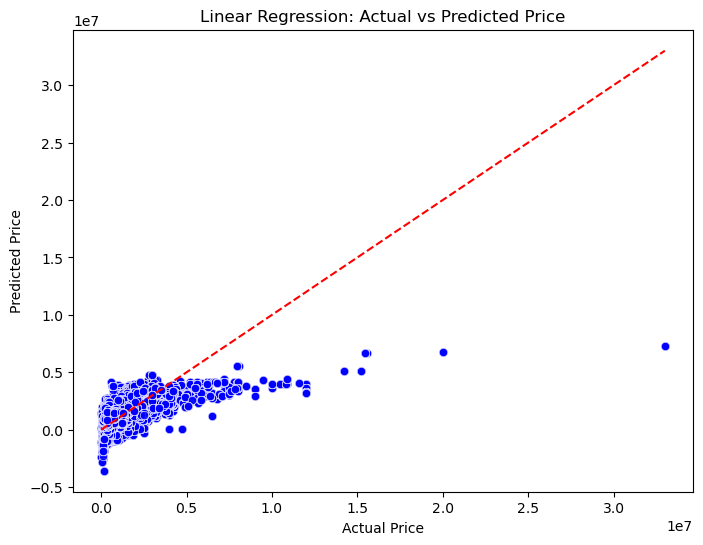

In [35]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, Imputer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# -----------------------------
# 1. Create Spark session (if not already)
# -----------------------------
spark = SparkSession.builder.appName("LinearRegressionPipeline").getOrCreate()

# -----------------------------
# 2. Handle missing values
# -----------------------------
# Replace missing numeric values with mean
imputer = Imputer(
    inputCols=["mileage", "year", "power"], 
    outputCols=["mileage", "year", "power"]
).setStrategy("mean")

df_imputed = imputer.fit(df).transform(df)  # df = your original DataFrame

# -----------------------------
# 3. Assemble features
# -----------------------------
feature_cols = ["mileage", "year", "power"]
assembler = VectorAssembler(
    inputCols=feature_cols, 
    outputCol="features"
)
df_assembled = assembler.transform(df_imputed)

# -----------------------------
# 4. Train-test split
# -----------------------------
train_df, test_df = df_assembled.randomSplit([0.8, 0.2], seed=42)

# -----------------------------
# 5. Build and train Linear Regression model
# -----------------------------
lr = LinearRegression(featuresCol="features", labelCol="price")
lr_model = lr.fit(train_df)

# -----------------------------
# 6. Make predictions
# -----------------------------
predictions = lr_model.transform(test_df)
predictions.select("price", "prediction").show(10)

# -----------------------------
# 7. Evaluate model
# -----------------------------
evaluator_rmse = RegressionEvaluator(
    labelCol="price", predictionCol="prediction", metricName="rmse"
)
evaluator_r2 = RegressionEvaluator(
    labelCol="price", predictionCol="prediction", metricName="r2"
)

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)

# -----------------------------
# 8. Optional: Convert to Pandas for plotting
# -----------------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pandas_df = predictions.select("price", "prediction").toPandas()
pandas_df = pandas_df.rename(columns={"price": "actual"})

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x="actual", y="prediction", data=pandas_df, alpha=0.6, color="blue")
plt.plot([pandas_df.actual.min(), pandas_df.actual.max()],
         [pandas_df.actual.min(), pandas_df.actual.max()], "r--")
plt.title("Linear Regression: Actual vs Predicted Price")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()


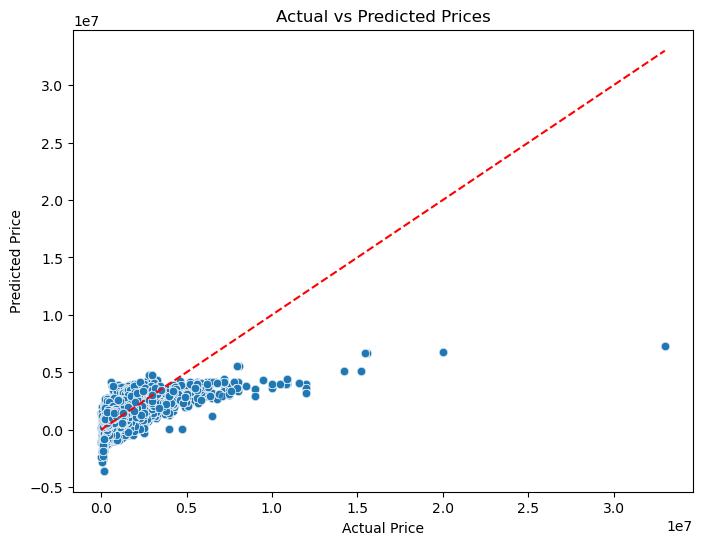

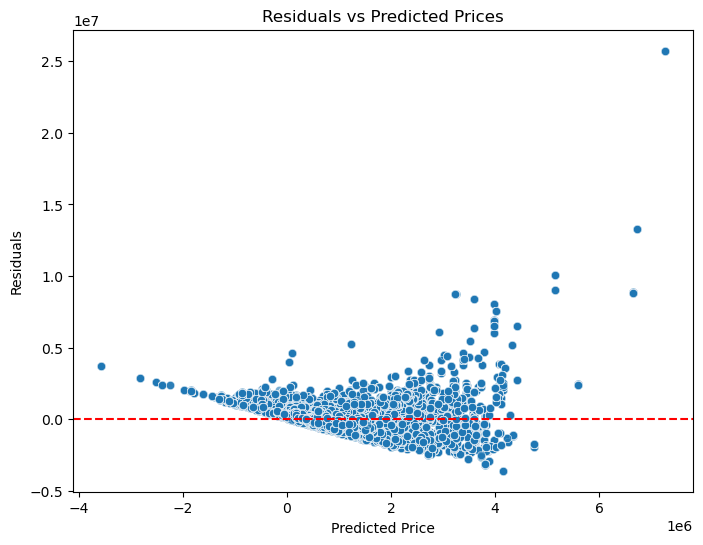

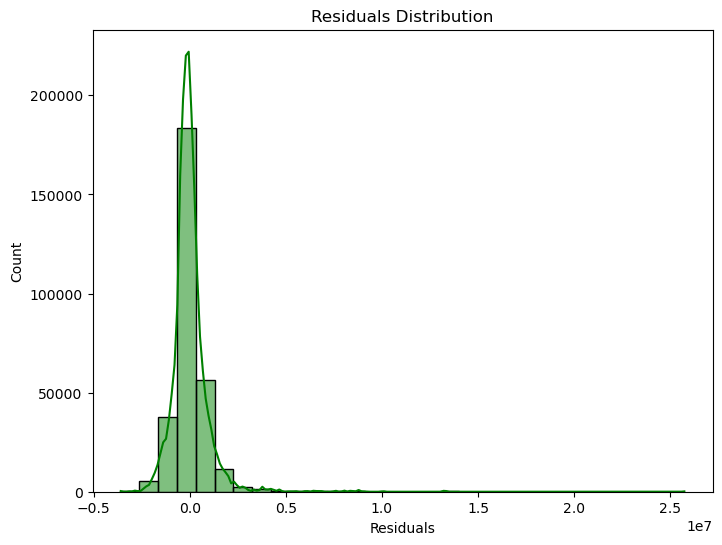

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame → Pandas
pandas_df = predictions.select("price", "prediction").toPandas()
pandas_df = pandas_df.rename(columns={"price": "actual"})

# Compute residuals
pandas_df["residuals"] = pandas_df["actual"] - pandas_df["prediction"]

# -----------------------------
# 1. Actual vs Predicted Plot
# -----------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x="actual", y="prediction", data=pandas_df, alpha=0.6)
plt.plot([pandas_df.actual.min(), pandas_df.actual.max()],
         [pandas_df.actual.min(), pandas_df.actual.max()], "r--")
plt.title("Actual vs Predicted Prices")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()

# -----------------------------
# 2. Residuals vs Predicted Plot
# -----------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x="prediction", y="residuals", data=pandas_df, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Predicted Prices")
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.show()

# -----------------------------
# 3. Residuals Distribution Plot
# -----------------------------
plt.figure(figsize=(8,6))
sns.histplot(pandas_df["residuals"], bins=30, kde=True, color="green")
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.show()


In [66]:
pandas_df = predictions.select("price", "mileage", "year", "power", "cluster").toPandas()


AnalysisException: Column 'cluster' does not exist. Did you mean one of the following? [power, mileage, price, year, features, prediction, features_raw];
'Project [price#440, mileage#437, year#436, power#439, 'cluster]
+- Project [price#440, mileage#437, year#436, power#439, features_raw#2264, features#2304, UDF(features#2304) AS prediction#3215]
   +- Project [price#440, mileage#437, year#436, power#439, features_raw#2264, UDF(features_raw#2264) AS features#2304]
      +- Project [price#440, mileage#437, year#436, power#439, UDF(struct(price_double_VectorAssembler_6ca177ace68d, cast(price#440 as double), mileage, mileage#437, year, year#436, power, power#439)) AS features_raw#2264]
         +- Filter atleastnnonnulls(4, price#440, mileage#437, year#436, power#439)
            +- Project [price#440, mileage#437, year#436, power#439]
               +- Project [brand#431, name#432, bodyType#433, color#434, fuelType#435, year#436, mileage#437, transmission#438, power#439, price#440, vehicleConfiguration#441, engineName#442, engineDisplacement#443, date#444, location#445, link#446, parse_date#447, CASE WHEN (price#440 > 1000000) THEN 1 ELSE 0 END AS Churn#2028]
                  +- Filter atleastnnonnulls(17, brand#431, name#432, bodyType#433, color#434, fuelType#435, year#436, mileage#437, transmission#438, power#439, price#440, vehicleConfiguration#441, engineName#442, engineDisplacement#443, date#444, location#445, link#446, parse_date#447)
                     +- Relation [brand#431,name#432,bodyType#433,color#434,fuelType#435,year#436,mileage#437,transmission#438,power#439,price#440,vehicleConfiguration#441,engineName#442,engineDisplacement#443,date#444,location#445,link#446,parse_date#447] csv


In [67]:
pandas_df = final_predictions.select("price", "mileage", "year", "power", "cluster").toPandas()


In [68]:
print(pandas_df.columns)


Index(['price', 'mileage', 'year', 'power', 'cluster'], dtype='object')


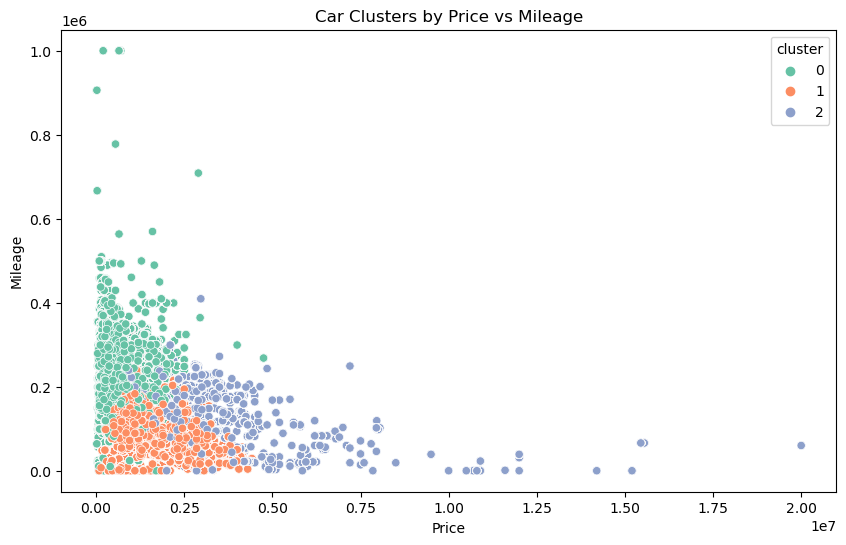

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pandas_df, x="price", y="mileage", hue="cluster", palette="Set2")
plt.title("Car Clusters by Price vs Mileage")
plt.xlabel("Price")
plt.ylabel("Mileage")
plt.show()


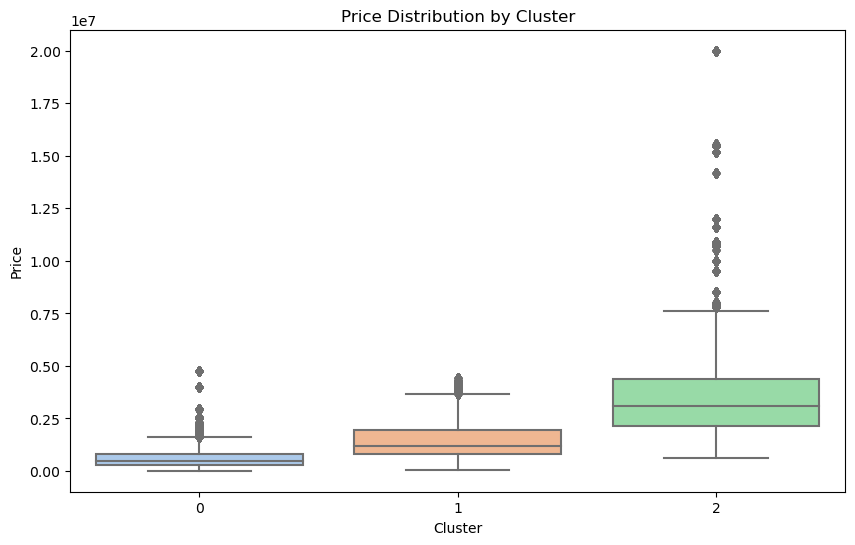

In [70]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=pandas_df, x="cluster", y="price", palette="pastel")
plt.title("Price Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Price")
plt.show()


In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Assuming you already have features vectorized as 'features' and your label is 'price'
lr = LinearRegression(featuresCol="features", labelCol="price")

# Train-test split
train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)
lr_model = lr.fit(train_data)

# Predict on test data
predictions = lr_model.transform(test_data)

# Evaluate predictions
evaluator_rmse = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"RMSE: {rmse}")
print(f"R2: {r2}")


IllegalArgumentException: features does not exist. Available: brand, name, bodyType, color, fuelType, year, mileage, transmission, power, price, vehicleConfiguration, engineName, engineDisplacement, date, location, link, parse_date

In [73]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Example: let's say you want to use 'year', 'mileage', 'power' as features
feature_cols = ['year', 'mileage', 'power']

# Create the assembler to combine the features into one vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

# Transform your dataframe to add 'features' column
df_with_features = assembler.transform(df)

# Now split the data
train_data, test_data = df_with_features.randomSplit([0.7, 0.3], seed=42)

# Initialize the Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='price')

# Fit the model
lr_model = lr.fit(train_data)

# Predict on test data
predictions = lr_model.transform(test_data)

# Show predictions
predictions.select('features', 'price', 'prediction').show(5)


25/10/02 00:25:29 WARN Instrumentation: [4e0ce8b3] regParam is zero, which might cause numerical instability and overfitting.
25/10/02 00:25:31 WARN TaskSetManager: Lost task 0.0 in stage 405.0 (TID 1100) (my-dataproc-cluster-w-0.us-central1-a.c.quiet-notch-473823-f9.internal executor 20): org.apache.spark.SparkException: Failed to execute user defined function (VectorAssembler$Lambda$4520/0x0000000801ae0040: (struct<year:double,mileage:double,power:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:189)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenS

Py4JJavaError: An error occurred while calling o1370.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 405.0 failed 4 times, most recent failure: Lost task 0.3 in stage 405.0 (TID 1106) (my-dataproc-cluster-w-0.us-central1-a.c.quiet-notch-473823-f9.internal executor 20): org.apache.spark.SparkException: Failed to execute user defined function (VectorAssembler$$Lambda$4520/0x0000000801ae0040: (struct<year:double,mileage:double,power:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:189)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1236)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1237)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:855)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:855)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1505)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 31 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2717)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2653)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2652)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2652)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1189)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1189)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1189)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2913)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2855)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2844)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:959)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2293)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2388)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1174)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1168)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$2(RDD.scala:1267)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1228)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1214)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1214)
	at org.apache.spark.ml.optim.WeightedLeastSquares.fit(WeightedLeastSquares.scala:107)
	at org.apache.spark.ml.regression.LinearRegression.trainWithNormal(LinearRegression.scala:452)
	at org.apache.spark.ml.regression.LinearRegression.$anonfun$train$1(LinearRegression.scala:346)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.regression.LinearRegression.train(LinearRegression.scala:328)
	at org.apache.spark.ml.regression.LinearRegression.train(LinearRegression.scala:185)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:151)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:115)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function (VectorAssembler$$Lambda$4520/0x0000000801ae0040: (struct<year:double,mileage:double,power:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:189)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1236)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1237)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:855)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:855)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1505)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 31 more


In [74]:
df_clean = df.na.drop(subset=feature_cols)
df_with_features = assembler.transform(df_clean)


In [75]:
from pyspark.ml.feature import Imputer

imputer = Imputer(inputCols=feature_cols, outputCols=feature_cols)
df_imputed = imputer.fit(df).transform(df)
df_with_features = assembler.transform(df_imputed)


In [78]:

from pyspark.sql import functions as F
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in feature_cols]).show()



+------+-------+-----+
|  year|mileage|power|
+------+-------+-----+
|583041|   6864|14240|
+------+-------+-----+



In [79]:
df_clean = df.na.drop(subset=feature_cols)


In [84]:
import VectorAssembler

from pyspark.ml.feature import VectorAssembler


assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
df_final = assembler.transform(df_imputed)  # or df_clean if you dropped nulls
import VectorAssembler

ModuleNotFoundError: No module named 'VectorAssembler'

In [85]:
from pyspark.ml.feature import VectorAssembler

# define feature columns
feature_cols = ['year', 'mileage', 'power']

# create the assembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

# apply it to your dataframe
df_final = assembler.transform(df_imputed)  # or df_clean if you removed nulls


In [86]:
train_data, test_data = df_final.randomSplit([0.7, 0.3], seed=42)

lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)


25/10/02 00:34:23 WARN Instrumentation: [f91006b2] regParam is zero, which might cause numerical instability and overfitting.


In [87]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# Assume df_imputed is your cleaned dataframe

feature_cols = ['year', 'mileage', 'power']  # update this list as per your dataset

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
df_final = assembler.transform(df_imputed)

# Train-test split
train_data, test_data = df_final.randomSplit([0.7, 0.3], seed=42)

# Create LinearRegression model with regularization parameter
lr = LinearRegression(featuresCol='features', labelCol='price', regParam=0.1)

# Train the model
lr_model = lr.fit(train_data)

# Make predictions
predictions = lr_model.transform(test_data)

# Show some predictions
predictions.select('price', 'prediction').show(5)


+------+------------------+
| price|        prediction|
+------+------------------+
|650000|2144177.5024403036|
|650000|2144177.5024403036|
|650000|2144177.5024403036|
|650000|2144177.5024403036|
|650000|2144177.5024403036|
+------+------------------+
only showing top 5 rows



In [88]:
print("Coefficients: ", lr_model.coefficients)
print("Intercept: ", lr_model.intercept)


Coefficients:  [69973.46733611343,-2.0520036158546526,9911.017479078813]
Intercept:  -140372336.7336897


In [89]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data =", rmse)

r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print("R-squared (R2) on test data =", r2)


Root Mean Squared Error (RMSE) on test data = 979169.9746121619


R-squared (R2) on test data = 0.48480815154912904
